In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go
import time
from datetime import datetime
from datetime import datetime as dt
import numpy as np
import plotly.express as px
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import mglearn
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from fbprophet import Prophet
import pystan

• FG_avg (en W=m2) : le flux global\
• FD_avg (en W=m2) : le flux diffus\
• Patm_avg (en hPa) : la pression atmosphérique\
• RH_avg (en %) : le taux d’humidité dans l’air\
• Text_avg (en °C) : la température extérieure\
• WD_MeanUnitVector (en degré) : la direction du vent\
• WS_avg (en m/s) : la vitesse du vent\

In [2]:
df1 = pd.read_csv('saintandre_2014_2015.csv')
df1['Kb'] = (df1['FG_Avg']-df1['FD_Avg'])/df1['FG_Avg']
df1.tail()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,Timestamp,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb
1049430,2015-12-30 23:56:00,10.540,1.482,989.9000,72.78333,22.40000,182.6632,3.850000,-6.112011
1049431,2015-12-30 23:57:00,4.730,4.787,989.8167,73.20000,22.40000,172.7405,3.966667,0.011907
1049432,2015-12-30 23:58:00,1.767,4.673,989.8000,73.48333,22.36667,193.0020,3.833333,0.621870
1049433,2015-12-30 23:59:00,10.320,4.559,989.8000,73.10000,22.30000,191.8352,4.166667,-1.263654
1049434,2015-12-31 00:00:00,1.596,4.616,989.8000,72.91666,22.30000,193.6581,4.283333,0.654246


Nous allons prédire l'indice de fraction directe
$$Kb = \frac{FD - FG}{FG}$$

In [3]:
df1.isnull().sum()

Timestamp              0
FD_Avg                 0
FG_Avg               343
Patm_Avg               0
RH_Avg                 0
Text_Avg               0
WD_MeanUnitVector      0
WS_Mean                0
Kb                   343
dtype: int64

In [4]:
df1.describe()

,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb
count,1.049435e+06,1.049092e+06,1.049435e+06,1.049435e+06,1.049435e+06,1.049435e+06,1.049435e+06,1.049092e+06
mean,1.199268e+02,2.515588e+02,9.921140e+02,7.314443e+01,2.250207e+01,1.511194e+02,3.143705e+00,-3.941993e-01
std,2.265237e+02,4.280563e+02,3.468094e+01,8.994230e+00,2.727051e+00,7.451055e+01,1.780443e+00,1.924931e+00
min,1.366000e+00,6.840000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.515288e+01
25%,4.160000e+00,4.105000e+00,9.907000e+02,6.738333e+01,2.050000e+01,1.163792e+02,2.116667e+00,-2.702703e-02
50%,1.304000e+01,1.305000e+01,9.934000e+02,7.355000e+01,2.261667e+01,1.624941e+02,3.116667e+00,1.688457e-01
75%,1.510000e+02,3.609000e+02,9.965999e+02,7.946667e+01,2.440000e+01,1.910002e+02,4.150000e+00,7.020432e-01
max,1.789000e+03,2.786000e+03,1.003850e+03,9.480000e+01,3.315000e+01,3.599998e+02,2.443333e+01,9.360766e-01


In [5]:
##Suppression des valeurs aberrantes 
df1 = df1.loc[df1['Kb'] >= 0.0] 
df1 = df1.loc[df1['Kb'] <= 1.0] 
df1.shape

(772438, 9)

In [6]:
df1['date'] = pd.to_datetime(df1['Timestamp']).dt.date
df1['date']  = pd.to_datetime(df1['date'])
df1['date'] = df1['date'].dt.strftime('%Y')
df1

,Timestamp,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb,date
0,2014-01-01 00:00:00,1.366,4.156,989.2000,77.03333,25.10000,158.4994,3.733333,0.671319,2014
1,2014-01-01 00:01:00,1.366,4.156,989.2000,77.01666,25.10000,162.9868,4.100000,0.671319,2014
2,2014-01-01 00:02:00,1.366,4.156,989.1333,76.98333,25.10000,160.8324,3.683333,0.671319,2014
3,2014-01-01 00:03:00,1.366,9.790,989.1333,77.10000,25.10000,156.6565,4.283333,0.860470,2014
6,2014-01-01 00:06:00,1.366,1.423,989.0999,77.20000,25.10000,166.1956,4.116667,0.040056,2014
...,...,...,...,...,...,...,...,...,...,...
1049428,2015-12-30 23:54:00,1.596,4.445,989.9000,72.66666,22.46667,187.3379,4.766667,0.640945,2015
1049429,2015-12-30 23:55:00,1.368,4.331,989.9000,72.71667,22.41666,189.3382,4.016667,0.684138,2015
1049431,2015-12-30 23:57:00,4.730,4.787,989.8167,73.20000,22.40000,172.7405,3.966667,0.011907,2015
1049432,2015-12-30 23:58:00,1.767,4.673,989.8000,73.48333,22.36667,193.0020,3.833333,0.621870,2015


## Box Plot

In [7]:
#fig = px.box(df1,y= 'Kb', color = 'date')
#fig.show()

In [8]:
#fig1, ax1 = plt.subplots()
#df2 = df1.reset_index()
#df2= df1[['Timestamp','Kb']]
#ax1.set_title('Basic Plot')
#ax1.boxplot(df2)

### Corrélation de la station Saint Andre

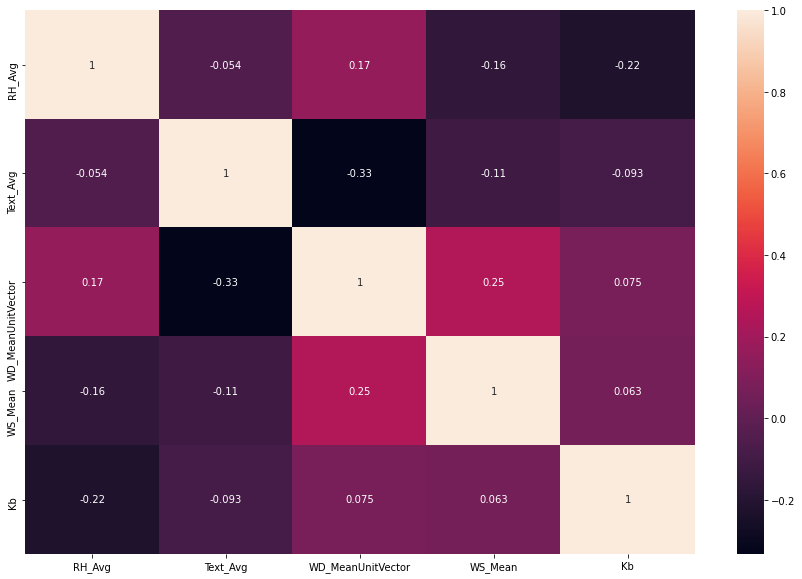

In [9]:
df1_stdr = df1.drop(['FD_Avg', 'FG_Avg', 'Patm_Avg'], axis =1)
corrMatrix = df1_stdr.corr()
plt.figure(figsize=(15,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

## train test split

In [10]:
df1['Date'] = pd.to_datetime(df1['Timestamp'])
df1.index = df1['Date'] 
df = df1.resample('H').mean() # on fait la moyenne sur chaque heure
#df_mouf = df.resample('D').mean() # on fait la moyenne sur chaque jour
df_tr =df.fillna(df.mean()) # on remplace els valeurs manquantes par la moyenne entre deux variables ou il situe la valeur NaN
X1 = df_tr[['FD_Avg', 'FG_Avg', 'Patm_Avg', 'RH_Avg', 'Text_Avg',
       'WD_MeanUnitVector', 'WS_Mean']]
y1 = df_tr['Kb']

In [11]:
'''
X1 = df1[['FD_Avg', 'FG_Avg', 'Patm_Avg', 'RH_Avg', 'Text_Avg',
       'WD_MeanUnitVector', 'WS_Mean']]
y1 = df1['Kb']'''

"\nX1 = df1[['FD_Avg', 'FG_Avg', 'Patm_Avg', 'RH_Avg', 'Text_Avg',\n       'WD_MeanUnitVector', 'WS_Mean']]\ny1 = df1['Kb']"

In [12]:
X_train1, X_test1, y_train1, y_test1 = tts(X1,y1, test_size=0.25, random_state=0)

## Régression linéaire

In [13]:
lm_stdr = LinearRegression()
lm_stdr.fit(X_train1, y_train1)

LinearRegression()

In [14]:
# Evaluation de l'ensemble d'apprentissage
from sklearn.metrics import r2_score
y_pred_stdr = lm_stdr.predict(X_train1)
rmse = (np.sqrt(mse(y_train1, y_pred_stdr)))
r2 = r2_score(y_train1, y_pred_stdr)
 
print('La performance du modèle sur lensemble dapprentissage')
print('--------------------------------------')
print('erreur quadratique moyenne est {:.2f}'.format(rmse))
print('le score R2 est {:.2f}'.format(r2))
print('\n')

La performance du modèle sur lensemble dapprentissage
--------------------------------------
erreur quadratique moyenne est 0.16
le score R2 est 0.58




In [15]:
# Evaluation de l'ensemble de test
from sklearn.metrics import r2_score
y_pred_stdr_test = lm_stdr.predict(X_test1)
rmse_test = (np.sqrt(mse(y_test1, y_pred_stdr_test)))
r2_test = r2_score(y_test1, y_pred_stdr_test)
 
print('La performance du modèle sur lensemble dapprentissage')
print('--------------------------------------')
print('erreur quadratique moyenne est {:.2f}'.format(rmse_test))
print('le score R2 est {:.2f}'.format(r2_test))
print('\n')

La performance du modèle sur lensemble dapprentissage
--------------------------------------
erreur quadratique moyenne est 0.16
le score R2 est 0.58




# Clustring
## Kmeans

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

In [17]:
kmeans = KMeans(n_clusters=3,init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X_train1)
'''kmeans.labels_
kmeans.inertia_
kmeans.cluster_centers_'''

'kmeans.labels_\nkmeans.inertia_\nkmeans.cluster_centers_'

In [18]:
# On affiche les 100 premiers adhésions
print("Adhésions au cluster :\n{}".format(kmeans.labels_[0:100]))

Adhésions au cluster :
[2 0 2 0 0 0 0 2 0 0 1 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 2 2 0 0 0 1 2 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 0 0 2 0 0 2 0 0 2 2]


Comme nous avons demandé trois clusters, les clusters sont numérotés de 0 à 2.

In [19]:
print("centres des clusters :\n{}".format(kmeans.cluster_centers_))

centres des clusters :
[[3.08015956e+01 4.70545968e+01 9.92053364e+02 7.55081855e+01
  2.16870976e+01 1.66221187e+02 2.92332277e+00]
 [1.26935637e+03 2.16412587e+03 9.90205881e+02 7.31763424e+01
  2.51962509e+01 1.15293893e+02 1.31818384e+00]
 [2.49573530e+02 6.34513464e+02 9.92150554e+02 6.69534999e+01
  2.44534322e+01 1.15491366e+02 3.91193710e+00]]


In [20]:
y_pred_km = kmeans.predict(X_train1)
print(y_pred_km[0:100])

[2 0 2 0 0 0 0 2 0 0 1 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 2 2 0 0 0 1 2 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 0 0 2 0 0 2 0 0 2 2]


In [21]:
'''plt.scatter(X_scaled[y_pred_km==0,0],X_scaled[y_pred_km==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X_scaled[y_pred_km==1,0],X_scaled[y_pred_km==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(X_scaled[y_pred_km==2,0],X_scaled[y_pred_km==2,1],s=50, c='green',label='Cluster3')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()'''

"plt.scatter(X_scaled[y_pred_km==0,0],X_scaled[y_pred_km==0,1],s=50, c='purple',label='Cluster1')\nplt.scatter(X_scaled[y_pred_km==1,0],X_scaled[y_pred_km==1,1],s=50, c='blue',label='Cluster2')\nplt.scatter(X_scaled[y_pred_km==2,0],X_scaled[y_pred_km==2,1],s=50, c='green',label='Cluster3')\nplt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')\nplt.title('')\nplt.xlabel('')\nplt.ylabel('')\nplt.legend()\nplt.show()"

Text(0.5, 1.0, 'Affectations de cluster et centres de cluster trouvés par k-means avec trois clusters')

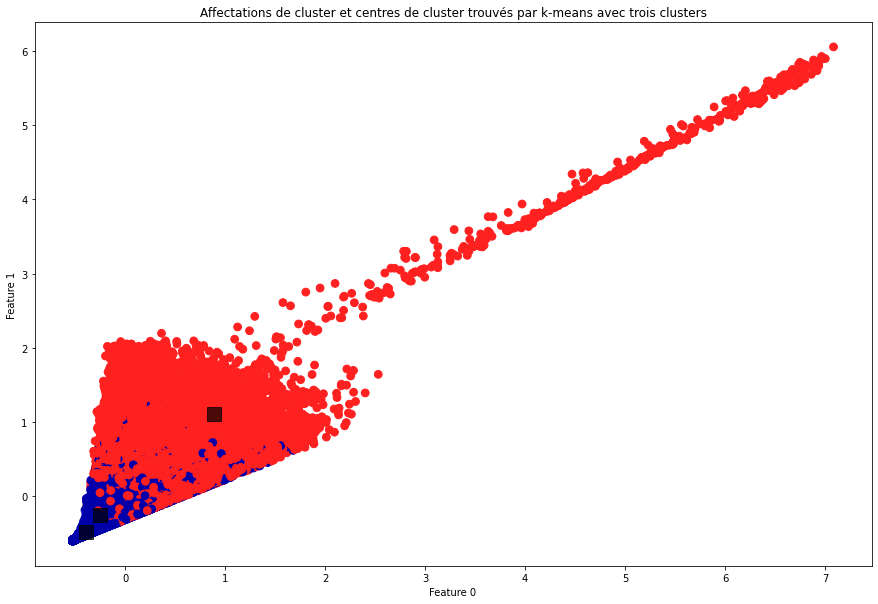

In [22]:
#Visualisation
#import mglearn
cl = kmeans.fit_predict(X_scaled)
# plot the cluster assignments
plt.figure(figsize=(15,10))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cl, cmap=mglearn.cm2, s=60)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=200,marker='s', c='black', alpha=0.7, label='Centroids')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title('Affectations de cluster et centres de cluster trouvés par k-means avec trois clusters')

## DBSCAN  

In [23]:
from sklearn.cluster import DBSCAN

In [24]:
db = DBSCAN(eps=0.3, min_samples=10)
db.fit(X_train1)

DBSCAN(eps=0.3, min_samples=10)

In [25]:
db.labels_[10:30]
#print(db.core_sample_indices_)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1], dtype=int64)

In [26]:
clusters = db.fit_predict(X_train1)
print("Cluster memberships:\n{}".format(clusters))

Cluster memberships:
[-1 -1 -1 ... -1 -1 -1]


In [27]:
#print("Accuracy: {:.2f}".format(accuracy_score(y_train1, clusters)))

AttributeError: 'DBSCAN' object has no attribute 'cluster_centers_'

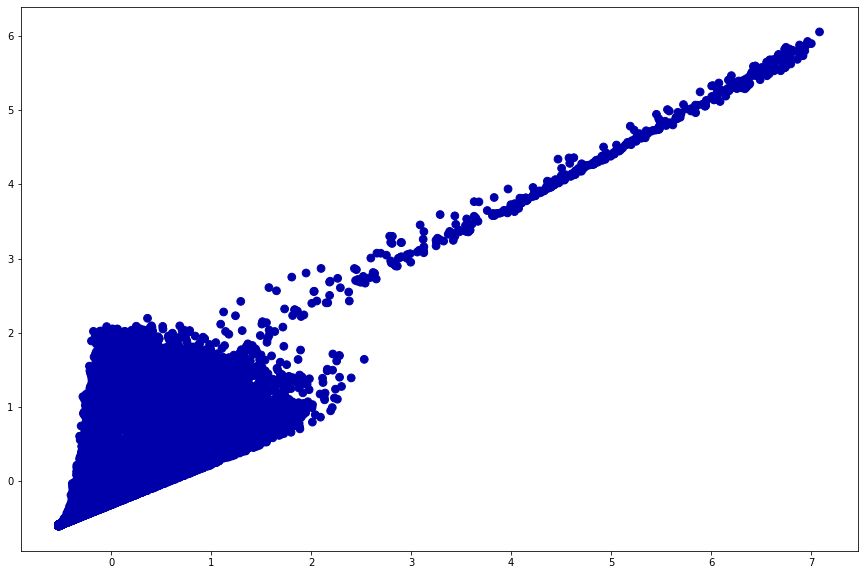

In [28]:
clusters = db.fit_predict(X_scaled)
# plot the cluster assignments
plt.figure(figsize=(15,10))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.scatter(kmeans.cluster_centers_[:,0], db.cluster_centers_[:,1],s=200,marker='s', c='black', alpha=0.7, label='Centroids')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# Séries Temporelles

In [29]:
df1['Date'] = pd.to_datetime(df1['Timestamp'])
df1.index = df1['Date'] 
df = df1.resample('H').mean() # on fait la moyenne sur chaque heure
df_stdr = df.resample('D').mean() # on fait la moyenne sur chaque jour
df_stdr =df_stdr.fillna(df.mean()) # on remplace els valeurs manquantes par la moyenne entre deux variables ou il situe la valeur NaN
df_stdr

,FD_Avg,FG_Avg,Patm_Avg,RH_Avg,Text_Avg,WD_MeanUnitVector,WS_Mean,Kb
Date,,,,,,,,
2014-01-01,499.256123,892.703389,987.695660,76.791420,24.783977,164.843101,4.254713,0.343981
2014-01-02,211.812035,841.601990,977.454316,92.429107,23.376673,147.761962,8.413765,0.759088
2014-01-03,539.697126,1236.782136,975.984922,82.038726,24.109948,136.335593,2.957871,0.656201
2014-01-04,972.179514,1837.107917,983.298019,79.799072,24.957940,94.368874,0.767095,0.515745
2014-01-05,1126.212432,2022.200827,988.042347,76.051390,24.245243,104.974782,0.729262,0.458824
...,...,...,...,...,...,...,...,...
2015-12-27,85.080368,315.374062,991.228830,70.079152,25.127195,148.805143,3.679668,0.568046
2015-12-28,117.605986,281.799306,992.685120,68.061345,25.530931,140.858548,3.492994,0.463720
2015-12-29,105.895476,230.387166,992.795944,76.820320,24.912581,164.982564,3.945696,0.349509


In [30]:
df_stdr.isna().sum()

FD_Avg               0
FG_Avg               0
Patm_Avg             0
RH_Avg               0
Text_Avg             0
WD_MeanUnitVector    0
WS_Mean              0
Kb                   0
dtype: int64

aucune valeur manquante

# Visualisations de masses de données de séries temporelles

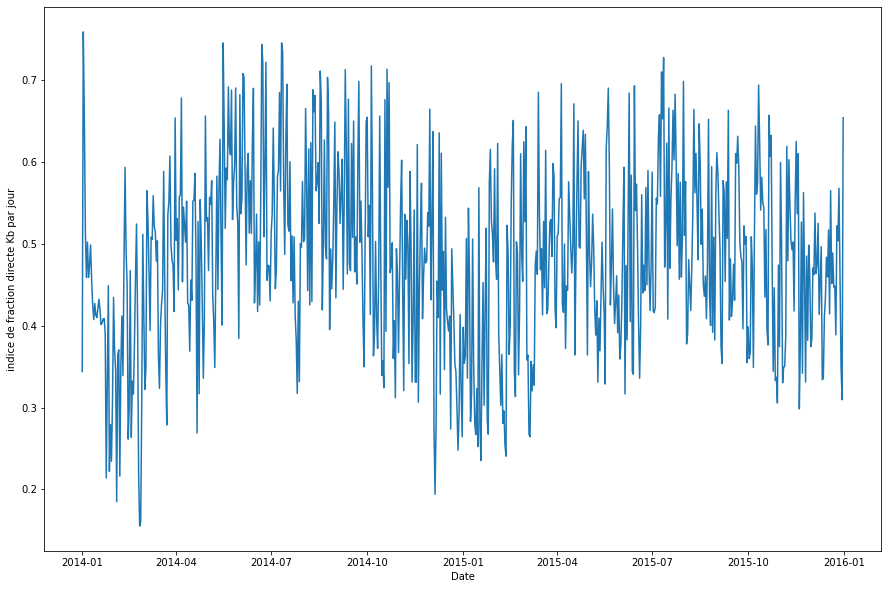

In [31]:
plt.figure(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel('indice de fraction directe Kb par jour')
plt.plot(df_stdr['Kb'])

Avant de pouvoir construire un modèle de prévision, nous devons nous assurer que la série temporelle est stationnaire.
Une façon de déterminer si une série temporelle donnée est stationnaire:

Statistiques roulantes : Tracer la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps (à l’œil nu, regardez si les lignes sont droites et parallèles à l’axe des x)

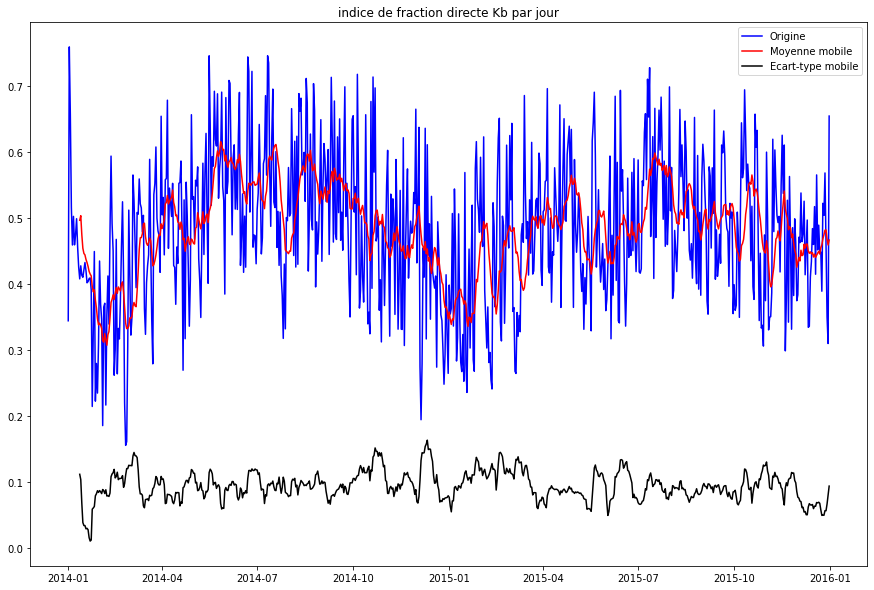

In [32]:
rolling_mean = df_stdr['Kb'].rolling(window = 12).mean()
rolling_std = df_stdr['Kb'].rolling(window = 12).std()
plt.figure(figsize=(15,10))
plt.plot(df_stdr['Kb'], color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('indice de fraction directe Kb par jour')
plt.show()

Comme vous pouvez le voir, la moyenne mobile et l’écart-type mobile de l'indice de fraction directe Kb restent stationaire avec le temps, Nous pouvons donc dire que la série temporelle est stationnaire.  

In [33]:
mdl = sm.tsa.statespace.SARIMAX(df_stdr['Kb'],order=(0, 0, 0),seasonal_order=(2, 2, 1, 7),enforce_stationarity=True,enforce_invertibility=True)
res = mdl.fit()
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                        Kb   No. Observations:                  730
Model:             SARIMAX(2, 2, [1], 7)   Log Likelihood                 490.624
Date:                   Thu, 06 May 2021   AIC                           -973.248
Time:                           02:52:51   BIC                           -954.953
Sample:                       01-01-2014   HQIC                          -966.184
                            - 12-31-2015                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.6044      0.038    -15.805      0.000      -0.679      -0.529
ar.S.L14      -0.3644      0.038     -9.705      0.000      -0.438      -0.291
ma.S.L7       -0.9989      0

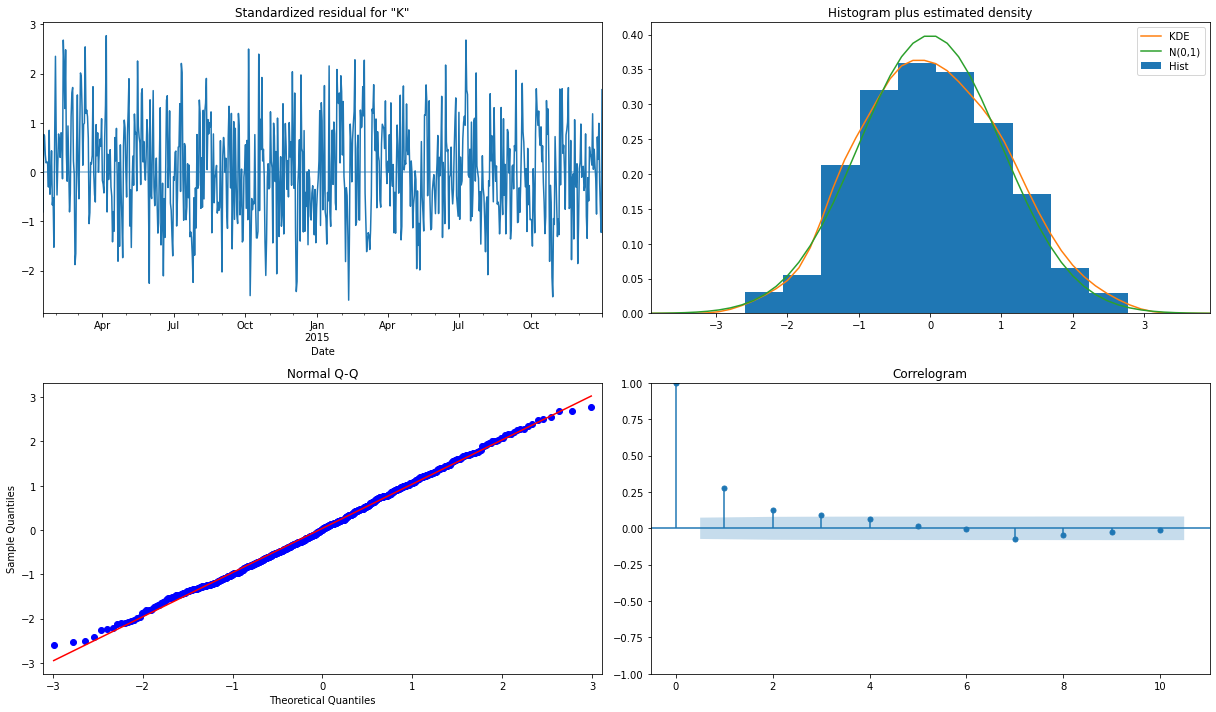

In [34]:
res.plot_diagnostics(figsize=(17, 10))
plt.tight_layout()
plt.show()

# prédiction de l’indice Kb de fraction directe à l’horizon H+1, H+2, …, J+1, J+2…

## Modèle de la Moyenne Mobile Auto-Régressive Intégrée (ARIMA)

C:\Users\Etudiant\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\Etudiant\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmode

<Figure size 1800x720 with 0 Axes>

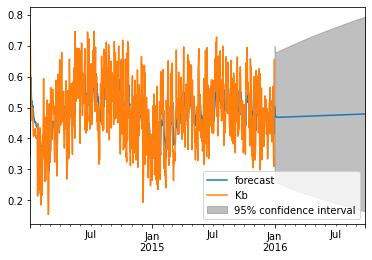

<Figure size 2520x720 with 0 Axes>

In [35]:
decomposition = seasonal_decompose(df_stdr['Kb']) 
model = ARIMA(df_stdr['Kb'], order=(2,1,2))
results = model.fit(disp=-1)
plt.figure(figsize=(25,10))
results.plot_predict(1,1000)
plt.figure(figsize=(35,10))
plt.show()

## Facebook Prophet

In [36]:
data_stdr = df_stdr.reset_index()

Nous n'avons besoin que les deux colonnes de notre ensemble de données (Date et Kb).\
Nous créons donc un nouveau Dataframe uniquement pour ces deux colonnes

In [37]:
data_stdr = data_stdr[['Date','Kb']]

Comme nous utilisons le modèle de 'Facebook Prophet' ici pour prédire l'indice de fraction directe, nous devons renommer les colonnes

In [38]:
data_stdr = data_stdr.rename(columns={'Date':'ds', 'Kb':'y'})
data_stdr

,ds,y
0,2014-01-01,0.343981
1,2014-01-02,0.759088
2,2014-01-03,0.656201
3,2014-01-04,0.515745
4,2014-01-05,0.458824
...,...,...
725,2015-12-27,0.568046
726,2015-12-28,0.463720
727,2015-12-29,0.349509
728,2015-12-30,0.309491


In [ ]:
model = Prophet()
model.fit(data_stdr)
predict = model.make_future_dataframe(periods=365)
forecast = model.predict(predict)
predict.tail()